# Plan:
1. The image is of shape 600x600x3 
2. The image is then divided by 255 to change range between for rgb 0-1 and scaled down to 200x200
3. The input array will be of shape nx(100x100x3) where n is no. of jpg file
4. The output will be divided into 2 heads
5. The first head will do regression and second will do classiffication
6. output array will contain 4 numbers for rectangle coordinate and 1 number for classification if face or not
7. while reading image if there is file in labels then add points by dividing by 200 because image is scaled down by 3 and bbox will range from 0 to 200, so bbox coordinates are between 0 to 1
8. if not present train data labels will contain 0,0,0.000001,0.0000001,0 the last 0 is for classification as no face

In [1]:
import glob
import os
import numpy as np
from PIL import Image
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential,Input
from tensorflow.keras.layers import Dense,GlobalMaxPooling2D
from tensorflow.keras.losses import BinaryCrossentropy,MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanSquaredError
from tensorflow.keras.applications.vgg16 import VGG16

In [3]:
path = os.path.join('data','train','images')
work_dir=os.getcwd()
os.chdir(path)

#select all jpeg images
file_names=glob.glob("*.jpg")
for index,file in enumerate(file_names):
    file_names[index]=file.split(".")[0]
    
#go back to orignal directory
os.chdir(work_dir)
file_names[:5]

['6c9baaf8-8f75-11ee-9b77-822a25ab1ec7',
 '6e90912a-8f75-11ee-9b77-822a25ab1ec7',
 '6da181fc-8f75-11ee-9b77-822a25ab1ec7',
 '6ef3b598-8f75-11ee-9b77-822a25ab1ec7',
 '6c5d119e-8f75-11ee-9b77-822a25ab1ec7']

In [5]:
os.getcwd()

'/Users/himanshupradhan/coding/Projects/ML/face-detection'

In [6]:
#n = no.of files and m = image dimensions 
n= len(file_names)
# n,m= len(file_names),(200*200*3)

X_train = np.zeros((n,100,100,3))
# X_train = np.zeros((n,m))
#5 outputs
y_train_points = np.zeros((n,4))
y_train_classification=np.zeros((n,1))

In [7]:
train_images_path=os.path.join('data','train','images')
train_labels_path=os.path.join('data','train','labels')

for ind,name in enumerate(file_names):
    #read image
    img = Image.open(os.path.join(train_images_path,f'{name}.jpg'))
    
    #resize image
    newsize = (100, 100)
    img = img.resize(newsize)
    
    img = np.asarray(img)
    #divide by 255 and reshape to vector
    img=img/255
    # img=img.reshape(-1,)
    
    #rows updating
    X_train[ind] = img
    
    try:
        label_file_name=os.path.join(train_labels_path,f'{name}.json')
        with open(label_file_name) as f:
            label = json.load(f)
            #since image scaled by 6 times divide by 3 and 100 for 0-1
            y_train_points[ind] = np.array(label['shapes'][0]['points']).reshape(4,)/(6*100)
            y_train_classification[ind] = 1
            

    except FileNotFoundError:
        # If file not found, set default values for the bounding box
        y_train_points[ind]=np.array([0,0,0.0000001,0.0000001])
        y_train_classification[ind] = 0   

# Testing if data loaded correctly

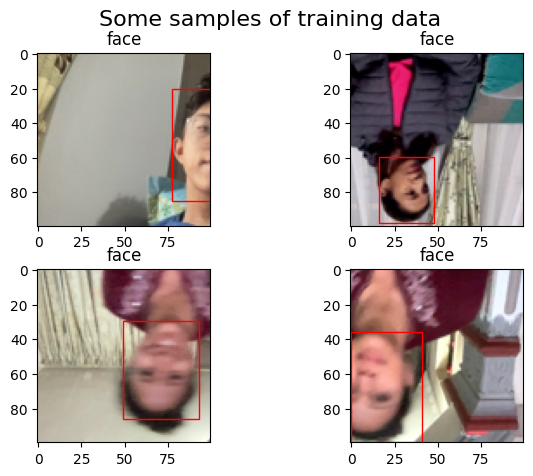

In [9]:
fig,axs=plt.subplots(2,2)

fig.suptitle('Some samples of training data', fontsize=16)
fig.tight_layout(pad=1.0)

for i in range(4):
    ind=random.randint(0,n-1)
    img=(X_train[ind] *255).astype(int)
    # img=(X_train[ind] *255).reshape(200,200,3).astype(int)
    

    points=y_train_points[ind]
    points=points*100

    x_min = points[0]
    y_min = points[1]
    w = points[2] - points[0]
    h = points[3] - points[1]
    
    tag="face" if y_train_classification[ind]>=0.5 else "no face"
    row = i // 2  # Calculate the row index in the subplot grid
    col = i % 2   # Calculate the column index in the subplot grid

    axs[row, col].imshow(img)
    axs[row, col].add_patch(Rectangle((x_min, y_min), w, h,
                                      edgecolor='red',
                                      fill=False))
    axs[row,col].title.set_text(tag)

# Now we train the model

## first let's try two different models one for classification and other for regression

In [46]:
100*100*3

30000

In [55]:
@tf.keras.utils.register_keras_serializable()
def custom_loss_function(y_true, y_pred):
    delta_points=tf.reduce_sum(tf.square(y_true[:2]-y_pred[:2]))
    
    h_pred=y_pred[3]-y_pred[1]
    w_pred=y_pred[2]-y_pred[0]
    h_true=y_true[3]-y_true[1]
    w_true=y_true[2]-y_true[0]
    
    delta_size=tf.reduce_sum(tf.square(h_true-h_pred)+tf.square(w_true-w_pred))
    
    return delta_points+delta_size


In [48]:
class_loss=BinaryCrossentropy()
reg_loss=custom_loss_function
opt=Adam(learning_rate=0.0001)

In [29]:
# input_layer=Input(shape=(120000,))
# l1=Dense(units=2000,activation='relu')(input_layer)
# l2=Dense(units=220,activation='relu')(l1)
# l3= Dense(units=50, activation='relu')(l2)

# class_l1=Dense(units=6, activation='relu')(l3)
# class_out= Dense(units=1,activation='sigmoid')(class_l1)

# reg_l1=Dense(units=12, activation='relu')(l3)
# reg_out= Dense(units=4,activation='sigmoid')(reg_l1)


In [49]:
input_layer=Input(shape=(100,100,3))

vgg= VGG16(include_top=False)(input_layer)

f1=GlobalMaxPooling2D()(vgg)
class_l1=Dense(units=2048, activation='relu')(f1)
class_out= Dense(units=1,activation='sigmoid',name='class_out')(class_l1)

f2=GlobalMaxPooling2D()(vgg)
reg_l1=Dense(units=2040, activation='relu')(f2)
reg_out= Dense(units=4,activation='sigmoid',name='reg_out')(reg_l1)


In [50]:
model=tf.keras.Model(input_layer,[class_out,reg_out])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_11[0][0]']            
                                                          8                                       
                                                                                                  
 global_max_pooling2d_4 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [51]:
model.compile(loss = [class_loss,reg_loss],optimizer = opt)

In [53]:
model.fit(X_train,[y_train_classification,y_train_points],epochs=10)

Epoch 1/10
53/53 [==============================] - 129s 2s/step - loss: 1.3073 - dense_9_loss: 0.1976 - dense_11_loss: 1.1097
Epoch 2/10
53/53 [==============================] - 133s 3s/step - loss: 0.6020 - dense_9_loss: 0.1194 - dense_11_loss: 0.4825
Epoch 3/10
53/53 [==============================] - 134s 3s/step - loss: 0.8586 - dense_9_loss: 0.1615 - dense_11_loss: 0.6972
Epoch 4/10
53/53 [==============================] - 132s 2s/step - loss: 0.7193 - dense_9_loss: 0.1303 - dense_11_loss: 0.5890
Epoch 5/10
53/53 [==============================] - 134s 3s/step - loss: 0.4936 - dense_9_loss: 0.0679 - dense_11_loss: 0.4257
Epoch 6/10
53/53 [==============================] - 133s 3s/step - loss: 0.3857 - dense_9_loss: 0.0514 - dense_11_loss: 0.3343
Epoch 7/10
53/53 [==============================] - 133s 3s/step - loss: 0.1266 - dense_9_loss: 0.0353 - dense_11_loss: 0.0913
Epoch 8/10
53/53 [==============================] - 133s 3s/step - loss: 0.1357 - dense_9_loss: 0.0212 - dense_

In [56]:
model.save_weights('model.h5')